In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import sys
sys.path.append('../')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

Below I synthesize two hourly datasets of the exact same length as the ETTh1 dataset. Time stamps are also generated so that the Informer / other model's time feature encoder works

In [2]:
from data_generator import SynthesisTS

# New Trend Framework

In [3]:
synth_maker = SynthesisTS(series_amount=1, seq_len=17420)

synth_maker.add_trend?

Signature:
synth_maker.add_trend(
    df=None,
    trend='Additive',
    trend_slope=0.01,
    trend_slope_increment=0.006,
    accumulated_retain_rate=0.5,
    trend_rate=1.00001,
    reversal=False,
    reversal_interval=2160,
)
Docstring:
Adds trends and optionally reversals to an existing synthesized time series.

Args:
    df(pd.DataFrame, optional): DataFrame containing the synthesized time series to apply trend to. Will use self.result if existing.
    trend(str): Trend type to apply ('Additive' or 'Multiplicative')
    trend_slope (float): Additive trend slope.
    trend_slope_increment (float): Increase trend_rate when coming up from a decreasing trend --- helps maintain overall rising trend.
    accumulated_retain_rate (float): How much of the accumulated trend to retain -- helps make additive trend reversals smoother
    trend_rate (float): Multiplicative trend rate.
    reversal (bool): Whether to apply trend reversals.
    reversal_interval (int): How often the reversal oc

In [4]:
SYNTH_PATH = '../SYNTHDataset/SYNTHh1.csv'
stationary_synth = pd.read_csv(SYNTH_PATH, index_col=0)
stationary_synth.index = pd.to_datetime(stationary_synth.index)

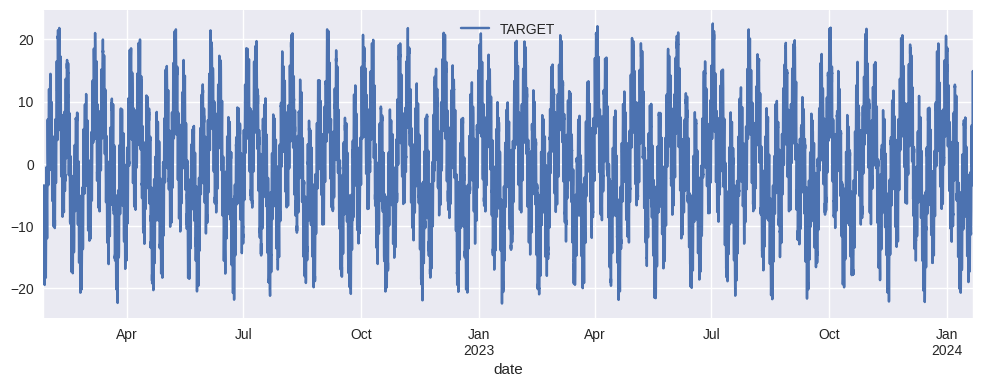

In [5]:
stationary_synth.plot(figsize=(12,4))
plt.show()

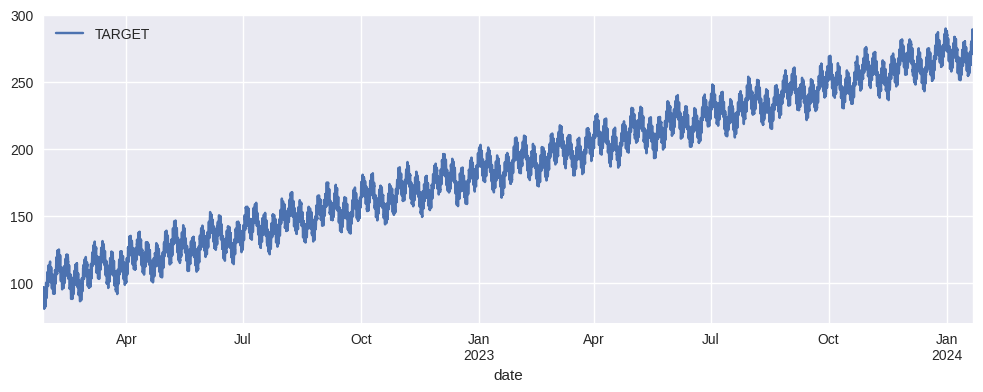

In [6]:
additive_test = synth_maker.add_trend(
    df=stationary_synth,
    trend='Additive',
    trend_slope=0.01,
    reversal=False,
)

additive_test.plot(figsize=(12,4))
plt.show()

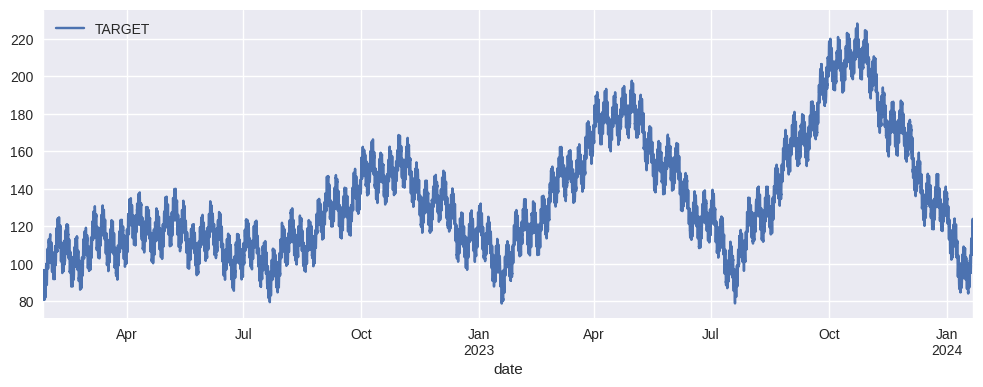

In [54]:
additive_test_reversal_quarterly = synth_maker.add_trend(
    df=stationary_synth,
    trend='Additive',
    trend_slope=0.01,
    reversal=True,
    reversal_interval=24*30*3,### quarterly- can mess around with this
    accumulated_retain_rate=1, ### can play around with this to make recoveries more abrupt   (0.5 for what we had in training)
    trend_slope_increment=0.015 ### Can play around this to make sure we keep overall increasing trend after recovering (0.005 for what we had in training)
)

additive_test_reversal_quarterly.plot(figsize=(12,4))
plt.show()

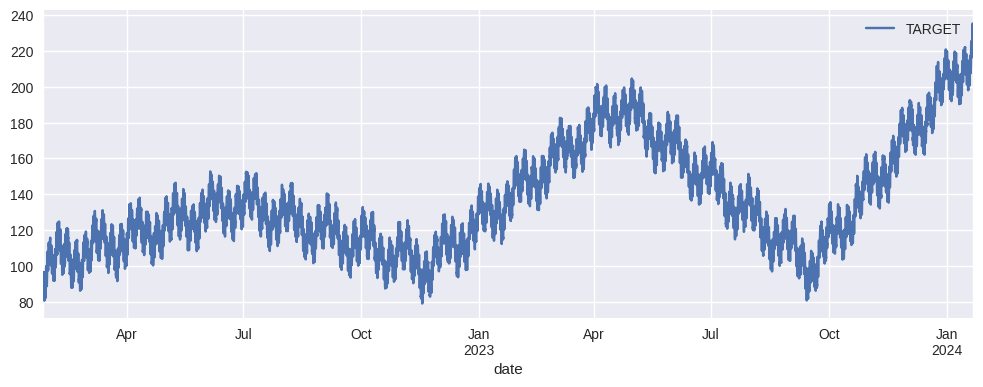

In [47]:
additive_test_reversal_biannual = synth_maker.add_trend(
    df=stationary_synth,
    trend='Additive',
    reversal=True,
    reversal_interval=24*30*5, ###### not actually bi-annual, set the last int in the multiplication to 6 but thi way it retains an icnreasing trend at end
    accumulated_retain_rate=1, ### can play around with this to make recoveries more abrupt   (0.5 for what we had in training)
    trend_slope_increment=0.015 ### Can play around this to make sure we keep overall increasing trend after recovering (0.005 for what we had in training)
)

additive_test_reversal_biannual.plot(figsize=(12,4))
plt.show()

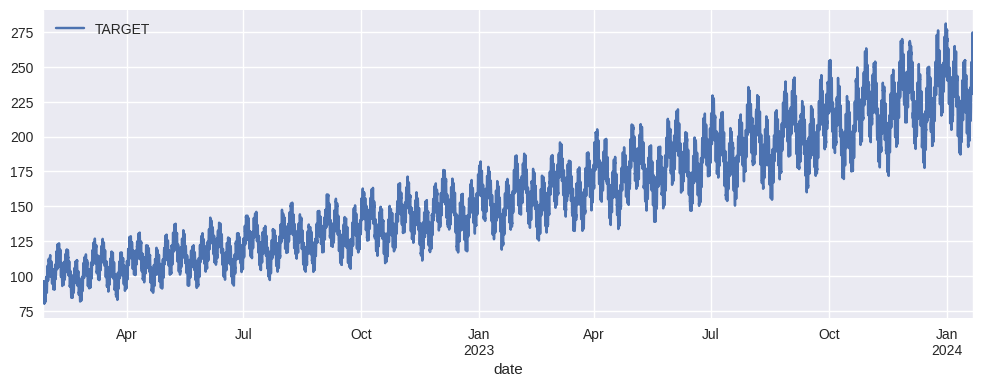

In [43]:
multiplicative_test = synth_maker.add_trend(
    df=stationary_synth,
    trend='Multiplicative',
    reversal=False,
    trend_rate=1.00005,
)

multiplicative_test.plot(figsize=(12,4))
plt.show()

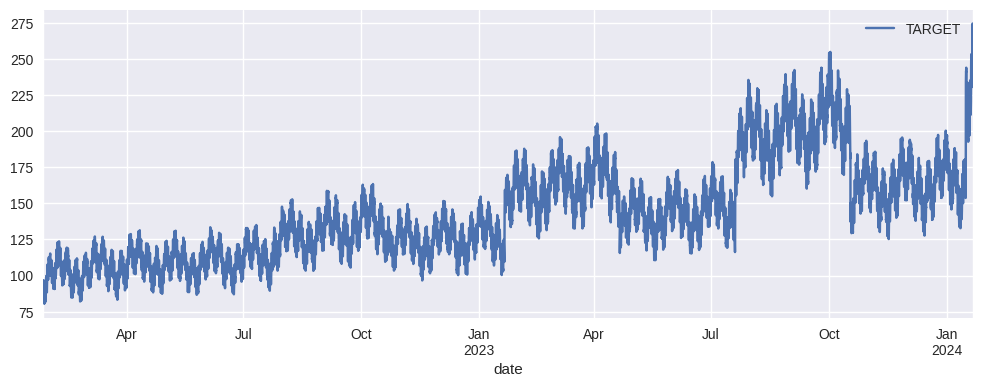

In [44]:
multiplicative_test_reversal_quarterly = synth_maker.add_trend(
    df=stationary_synth,
    trend='Multiplicative',
    reversal=True,
    trend_rate=1.00005,
    reversal_interval=24*30*3
)

multiplicative_test_reversal_quarterly.plot(figsize=(12,4))
plt.show()

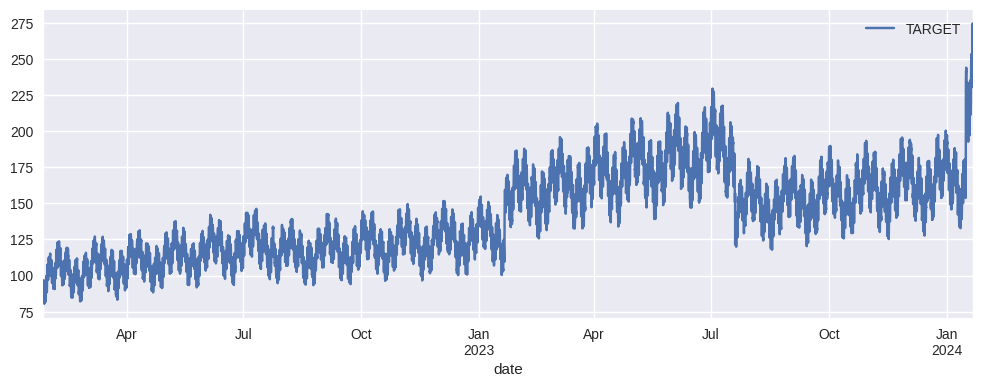

In [45]:
multiplicative_test_reversal_biannual = synth_maker.add_trend(
    df=stationary_synth,
    trend='Multiplicative',
    reversal=True,
    trend_rate=1.00005,
    reversal_interval=24*30*6
)

multiplicative_test_reversal_biannual.plot(figsize=(12,4))
plt.show()

# Some Analysis on $\texttt{StandardScaler()}$

In this section I refer to $\texttt{additive\_test}$ and $\texttt{additive\_test\_reversal\_quarterly}$ series.

In [57]:
# Assuming ts_additive is your DataFrame or Series
print('Descriptive Statistics of Synthetic Data with Additive Trend')
print('-'*80)
print(additive_test.describe().loc[['max', 'mean', 'std', 'min']])
print('='*80)
print('Descriptive Statistics of Synthetic Data with Additive Trend and Reversals')
print('-'*80)
print(additive_test_reversal_quarterly.describe().loc[['max', 'mean', 'std', 'min']])


Descriptive Statistics of Synthetic Data with Additive Trend
--------------------------------------------------------------------------------
          TARGET
max   289.637285
mean  187.076773
std    50.960614
min    80.752494
Descriptive Statistics of Synthetic Data with Additive Trend and Reversals
--------------------------------------------------------------------------------
          TARGET
max   228.131060
mean  134.829344
std    30.478505
min    78.807823


As it can be observed, the series have different means and standard deviations -- both higher when we just do an additive trend without reversals. This is likely to yield values on a different scale when using standardscaling -- especially when comparing the scaled test sets because the scale is fitted on the mean of the training set sequence, and the mean would have shifted in the test set sequence due to nonstationarity.

Below I simulate the train-val-test split of the $\texttt{Transformer}$ models

In [75]:
border_1 = 12*30*24
border_2 = border_1 + 4*30*24
border_3 = border_2 + 4*30*24

train_additive, val_additive, test_additive = additive_test[:border_1], additive_test[border_1:border_2], additive_test[border_2:border_3]
train_aditive_reversals, val_additive_reversals, test_additive_reversals = additive_test_reversal_quarterly[:border_1], additive_test_reversal_quarterly[border_1:border_2], additive_test_reversal_quarterly[border_2:border_3]


# I will only transform train and test sets and skip the validation set
scaler = StandardScaler()
scaled_train_additive = scaler.fit_transform(train_additive)
scaled_test_additive = scaler.transform(test_additive)

# Reinitialize just in case
scaler = StandardScaler()
scaled_train_additive_reversals = scaler.fit_transform(train_aditive_reversals)
scaled_test_additive_reversals = scaler.transform(test_additive_reversals)

Let us look into the descriptive statistics on the training sequences of both sets:

In [76]:
print('Training Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend')
print('-'*80)
print(f'max     {scaled_train_additive.max():.4f}\nmean     {scaled_train_additive.mean():.4f}\nstd     {scaled_train_additive.std():.4f}\nmin     {scaled_train_additive.min():.4f}')
print('='*80)
print('Training Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend and Reversals')
print('-'*80)
print(f'max     {scaled_train_additive_reversals.max():.4f}\nmean     {scaled_train_additive_reversals.mean():.4f}\nstd     {scaled_train_additive_reversals.std():.4f}\nmin     {scaled_train_additive_reversals.min():.4f}')
print('='*80)

Training Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend
--------------------------------------------------------------------------------
max     2.2714
mean     -0.0000
std     1.0000
min     -2.3738
Training Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend and Reversals
--------------------------------------------------------------------------------
max     2.9486
mean     -0.0000
std     1.0000
min     -2.3701


Now let us see how these shift in the test set:

In [77]:
print('Test Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend')
print('-'*80)
print(f'max     {scaled_test_additive.max():.4f}\nmean     {scaled_test_additive.mean():.4f}\nstd     {scaled_test_additive.std():.4f}\nmin     {scaled_test_additive.min():.4f}')
print('='*80)
print('Test Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend and Reversals')
print('-'*80)
print(f'max     {scaled_test_additive_reversals.max():.4f}\nmean     {scaled_test_additive_reversals.mean():.4f}\nstd     {scaled_test_additive_reversals.std():.4f}\nmin     {scaled_test_additive_reversals.min():.4f}')
print('='*80)

Test Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend
--------------------------------------------------------------------------------
max     4.4659
mean     3.2913
std     0.4447
min     2.1362
Test Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend and Reversals
--------------------------------------------------------------------------------
max     3.9952
mean     0.9133
std     1.3283
min     -2.3665


As it can be seen now the values are on a different range --- this should be the expected behavior as without reversing the trend, the time series sequence is highly non-stationary and the mean of the test set sequence is significantly higher than in the train set. 

While this does indeed render it impossible to compare model performance in terms off $\texttt{MSE}$ within datasets - i.e. make 1:1 comparison one Model A's performance on data with additive trend and data with additive trend and reversals, comparing across model's -- i.e. comparing Model A and Model B's performance on data with additive trend and reversals should be valid.


We could, alternatively use $\texttt{MinMaxScaler}$, but so far we had kept the $\texttt{StandardScaler}$ as the authors of the models included in our study all use that form of normalization. 

But even $\texttt{MinMaxScaler}$ will encounter a similar issue due to the non-stationarity.

### Looking into $\texttt{MinMaxScaler()}$

In [78]:
# I will only transform train and test sets and skip the validation set
scaler = MinMaxScaler()
scaled_train_additive = scaler.fit_transform(train_additive)
scaled_test_additive = scaler.transform(test_additive)

# Reinitialize just in case
scaler = MinMaxScaler()
scaled_train_additive_reversals = scaler.fit_transform(train_aditive_reversals)
scaled_test_additive_reversals = scaler.transform(test_additive_reversals)

In [79]:
print('Training Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend')
print('-'*80)
print(f'max     {scaled_train_additive.max():.4f}\nmean     {scaled_train_additive.mean():.4f}\nstd     {scaled_train_additive.std():.4f}\nmin     {scaled_train_additive.min():.4f}')
print('='*80)
print('Training Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend and Reversals')
print('-'*80)
print(f'max     {scaled_train_additive_reversals.max():.4f}\nmean     {scaled_train_additive_reversals.mean():.4f}\nstd     {scaled_train_additive_reversals.std():.4f}\nmin     {scaled_train_additive_reversals.min():.4f}')
print('='*80)

Training Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend
--------------------------------------------------------------------------------
max     1.0000
mean     0.5110
std     0.2153
min     0.0000
Training Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend and Reversals
--------------------------------------------------------------------------------
max     1.0000
mean     0.4456
std     0.1880
min     0.0000


In [80]:
print('Test Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend')
print('-'*80)
print(f'max     {scaled_test_additive.max():.4f}\nmean     {scaled_test_additive.mean():.4f}\nstd     {scaled_test_additive.std():.4f}\nmin     {scaled_test_additive.min():.4f}')
print('='*80)
print('Test Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend and Reversals')
print('-'*80)
print(f'max     {scaled_test_additive_reversals.max():.4f}\nmean     {scaled_test_additive_reversals.mean():.4f}\nstd     {scaled_test_additive_reversals.std():.4f}\nmin     {scaled_test_additive_reversals.min():.4f}')
print('='*80)

Test Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend
--------------------------------------------------------------------------------
max     1.4724
mean     1.2196
std     0.0957
min     0.9709
Test Sequence: Descriptive Statistics of Scaled Synthetic Data with Additive Trend and Reversals
--------------------------------------------------------------------------------
max     1.1968
mean     0.6173
std     0.2497
min     0.0007


Again, due to the fact that the additive trend series without reversals is highly non-stationary, it can be observed that in case of min-max scaling the min and max are higher than that of the series with reversals.

Therefore the case is the same here.


We can further do stationarity tests to show that both series are non-stationary, but the additive trend series without reversals is more so.

In [81]:
from statsmodels.tsa.stattools import adfuller

# Run KPSS test on entire sequences -- I could have mnamed the variables better
result_additive_only = adfuller(additive_test)
result_additive_reversals = adfuller(additive_test_reversal_quarterly)

In [82]:
print('Results on Additive Trend Series without Reversals')
print(f'ADF Statistic:  {result_additive_only[0]:.4f}')
print(f'p-value:  {result_additive_only[1]:.4f}')

Results on Additive Trend Series without Reversals
ADF Statistic:  -1.4364
p-value:  0.5647


In [83]:
print('Results on Additive Trend Series with Reversals')
print(f'ADF Statistic:  {result_additive_reversals[0]:.4f}')
print(f'p-value:  {result_additive_reversals[1]:.4f}')

Results on Additive Trend Series with Reversals
ADF Statistic:  -2.6005
p-value:  0.0929


In the $\texttt{ADF}$ test the $H_0$ is non-stationarity, which cannot be rejected in either of the datasets but as it can be observed, the series with additive trend without reversals has a much, much higher p-value.

# OLD SECTION / NO LONGER UP TO DATE: Generating Synthetic Series With Trend Reversals

In [3]:
SynthMaker = SynthesisTS(series_amount=1, seq_len=17420)

In [4]:
# Ran with default config given in data_generator.py
multip_reversal = SynthMaker.synthesize_single_series(trend='Multiplicative', reverse_trend=True, structural_break=False)

Generated: (100.0, 100.0, 100.0)
Generated: (101.81193257103718, 102.32552377524141, 103.48051785007709)
Multiplicative:(101.81193257103718, 102.32552377524141, 103.48051785007709)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48051785007709)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48258747078216)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48258747078216)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48258747078216)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48258747078216)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48258747078216)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48258747078216)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48258747078216)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48258747078216)
Multiplicative:(101.81193257103718, 102.32654703047916, 103.48258747078216)
Multiplicative:(101.81193257103718, 102.32654703047916, 103

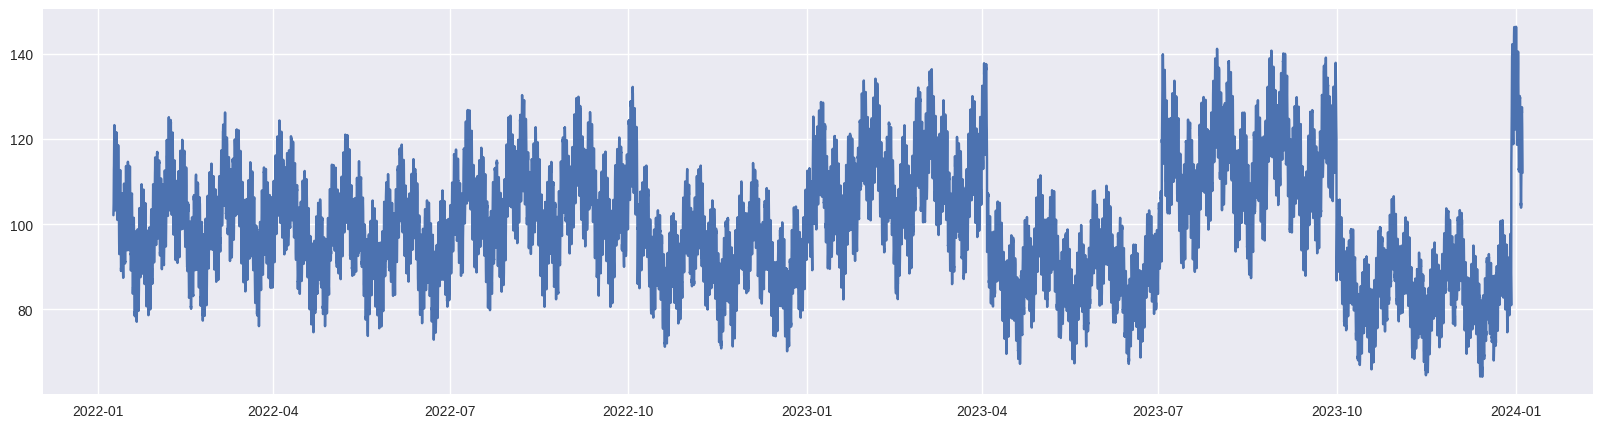

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(multip_reversal['date'], multip_reversal['TARGET'])
plt.show()

In [7]:
multip_reversal.to_csv('/home/RDC/anasashb/Dokumente/TransformersEnergyTS/SYNTHDataset/SYNTH_multiplicative_reversals.csv', index=False)


# Generating Synthetic Series With Additive Trend and Reversal

In [4]:
additive_reversal = SynthMaker.synthesize_single_series(trend='Additive', reverse_trend=True, structural_break=False)

Generated: (100.0, 100.0, 100.0)
Generated: (116.90656605176171, 115.49037895106116, 113.64778081029269)
Additive:(116.91656605176172, 115.49037895106116, 113.64778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.64778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.67778081029269)
Additive:(116.91656605176172, 115.51037895106116, 113.6

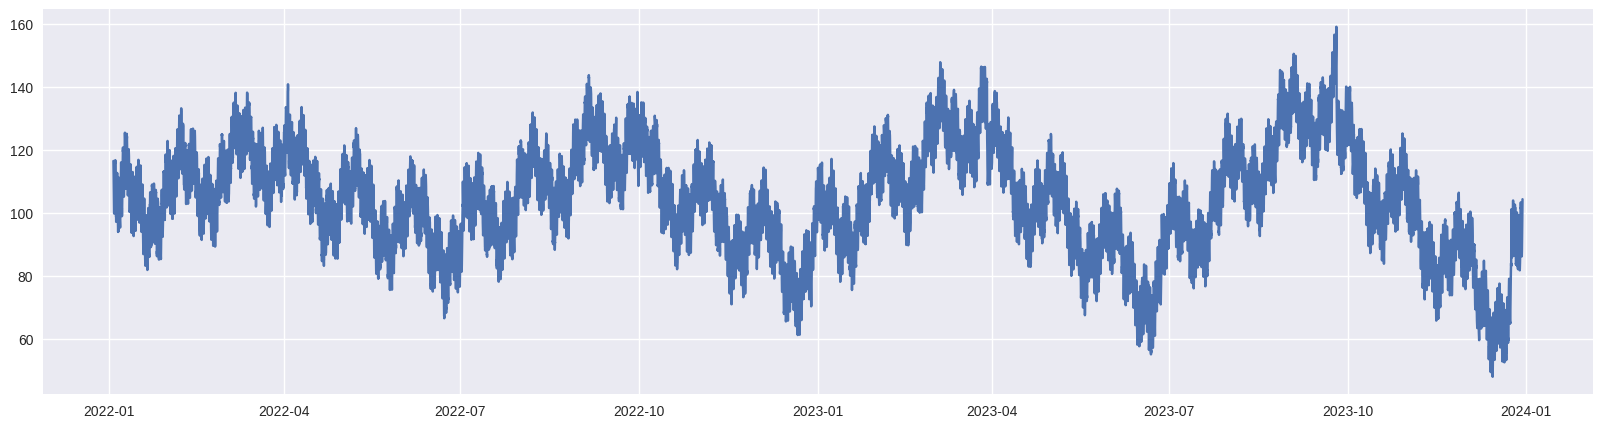

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(additive_reversal['date'], additive_reversal['TARGET'])
plt.show()

In [15]:
additive_reversal.to_csv('/home/RDC/anasashb/Dokumente/TransformersEnergyTS/SYNTHDataset/SYNTH_additive_reversals.csv', index=False)


# Old Code

In [ ]:
SynthMaker = SynthesisTS(series_amount=1, seq_len=17420)

In [ ]:
df1 = SynthMaker.synthesze_single_series()

In [ ]:
df1.head()

,date,TARGET
0,2022-01-25 22:00:00,-14.648879
1,2022-01-25 23:00:00,-11.896418
2,2022-01-26 00:00:00,-10.142491
3,2022-01-26 01:00:00,-8.443276
4,2022-01-26 02:00:00,-5.100413


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    17420 non-null  datetime64[ns]
 1   TARGET  17420 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 272.3 KB


In [ ]:
df1.describe()

,TARGET
count,17420.000000
mean,-0.028227
std,8.832361
min,-22.467177
25%,-6.258678
50%,0.045538
75%,6.217201
max,22.536278


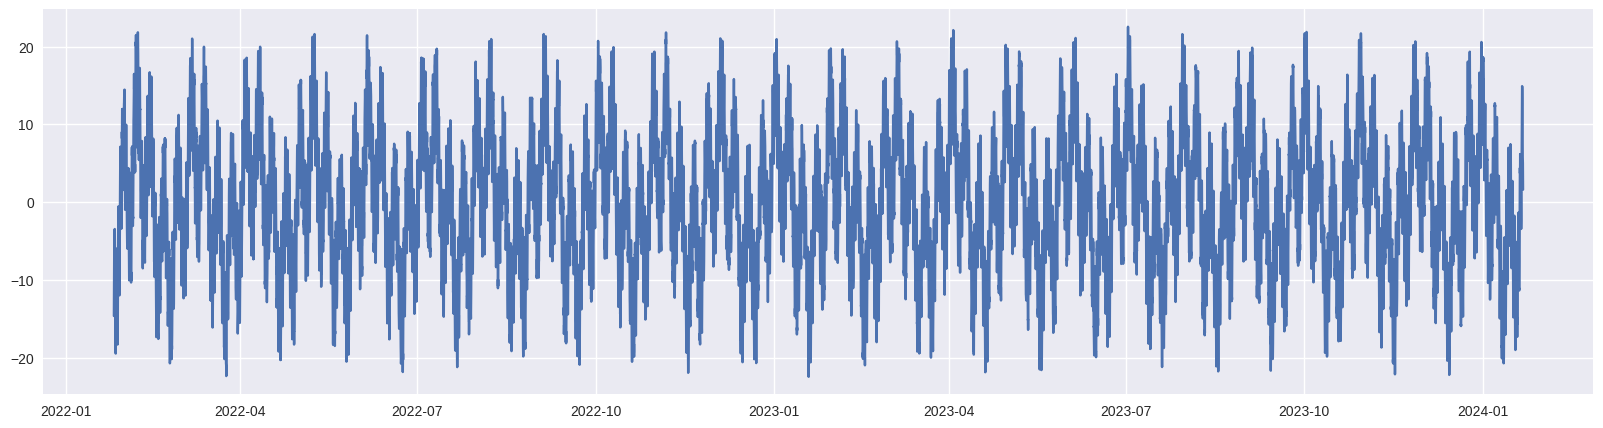

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df1['date'], df1['TARGET'])
plt.show()

In [ ]:
df2 = SynthMaker.synthesze_single_series()

In [ ]:
df2.head()

,date,TARGET
0,2022-01-04 20:00:00,-2.771159
1,2022-01-04 21:00:00,-3.925664
2,2022-01-04 22:00:00,-3.202413
3,2022-01-04 23:00:00,-0.233802
4,2022-01-05 00:00:00,0.627382


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    17420 non-null  datetime64[ns]
 1   TARGET  17420 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 272.3 KB


In [ ]:
df2.describe()

,TARGET
count,17420.000000
mean,0.086133
std,9.459860
min,-24.797278
25%,-6.713751
50%,0.120974
75%,6.854593
max,24.699640


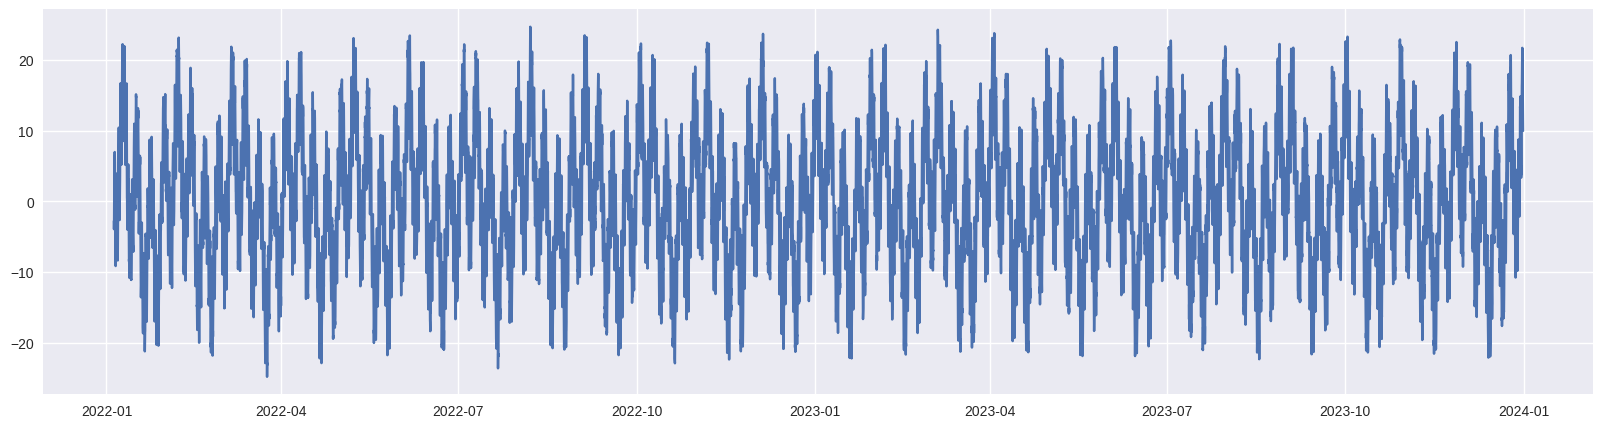

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df2['date'], df2['TARGET'])
plt.show()

In [ ]:
df1.to_csv('SYNTHh1.csv', index=False)
df2.to_csv('SYNTHh2.csv', index=False)